In [1]:
import pandas as pd
import math
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from MEBF import MEBF, matrix_subtract, matrix_product
import seaborn as sns
import time
from scipy import stats
%matplotlib inline
from numba import jit
import warnings

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True,formatter={'float_kind':'{:.6f}'.format})

In [3]:
data = pd.read_csv("../data/gse.csv",index_col = 0)

# Boolean Matrix Factorization

In [4]:
x_in_paper = pd.DataFrame(np.array([[1,1,0,1,1,1,0,1,0,0,0],[1,1,1,1,1,1,1,1,1,1,1],[1,1,0,1,1,1,1,0,1,0,1],
         [0,1,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,0,1,0,0],
         [0,0,0,1,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,0],[1,1,0,1,0,1,1,0,0,0,0],
         [1,1,1,1,1,0,0,0,0,0,0,],[1,1,0,1,1,0,0,0,0,0,0]]), index = range(1,12), columns = range(1,12))
A,B = MEBF(x_in_paper,0.8)

<AxesSubplot:>

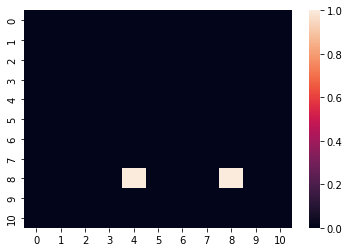

In [5]:
sns.heatmap(matrix_subtract(x_in_paper.values, matrix_product(A.values, B.values)), annot=False, vmin=0, vmax=1)

# BCV

### set iteration = 30

In [111]:
@jit
def bcv(data,times=20, num_comps=20, r=5, s=5):
    """
    parameter:
        data: 
            input data
            dropped rows and cols with all 0's
            scale not required
        times:
            iteration number of each number of components
        num_compons:
            total number of components
        r:
            the first shape of leave-out submatrix
        s:
            the second shape of leave-out submatrix
    
    function:
        leave out a submatrix A of shape (r,s)
        perform pca with number of components from [1, num_comps] with iteration equal to times
        perform bcv to compute A', and its error
    
    return:
        error, under components and iterations
        1-q2_A, the variance of 1 - var(A-A')/var(A), indicates how good A could be predicted      
    """
    # times = 15
    # num_comps = 25
    x = pd.DataFrame(scale(data),index = data.index, columns = data.columns)
    error = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    var_A = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    # iterate over number of components
    for num in range(1,num_comps+1):
        for time in range(1,times+1):
            # shuffle x
            x = x[np.random.permutation(x.columns)]
            x = x.reindex(np.random.permutation(x.index))
            # leave out submatrix
            A = x.values[:r,:s]
            B = x.values[:r,s:]
            C = x.values[r:,:s]
            D = x.values[r:,s:]
            # perform PCA
            pca = PCA(n_components = num)
            pca.fit(D)
            pca_df = pca.transform(D)
            D_approx = pca.inverse_transform(pca_df)
            A_approx = np.dot( np.dot(B,np.linalg.pinv(D_approx)), C)
            residule = A_approx - A
            """
            if (sum(np.abs(residule)).sum() > 10000):
                error.loc[time][num] = 500
            else: 
                error.loc[time][num] = sum(np.abs(residule)).sum()
            """
            error.loc[time][num] = sum(np.abs(residule)).sum()
            var_A.loc[time][num] = np.var(residule) / np.var(A)
    q2_A = pd.DataFrame(np.array(np.mean(var_A)).reshape(1,-1),columns = var_A.columns)
    q2_A = 1 - q2_A
    q2_A[q2_A < 0] = 0
    return error,  q2_A

## Personally, I prefer 5%

In [99]:
# preprocess on data
# first, drop rows and cols with all 0s
pre = data.copy()
# pre = pre.loc[(pre!=0).any(axis=1)]
# pre = pre.loc[:,(pre!= 0).any(axis=0)]

In [100]:
# choose rows and columns with least 0's
pre[pre!=0] = 1
idx = pre.eq(1).sum(axis=1).sort_values(ascending=False).index
pre = pre.reindex(idx)
cols = pre.eq(1).sum(axis=0).sort_values(ascending=False).index
pre = pre[cols]

In [128]:
# choose 1000 x 1000 left-upper corner submatrix
gse = data.copy()
gse = gse[pre.columns[0:1000]]
gse = gse.loc[pre.index[0:1000]]

In [132]:
times = 30
num_comps = 50
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse,times,num_comps,10,10)

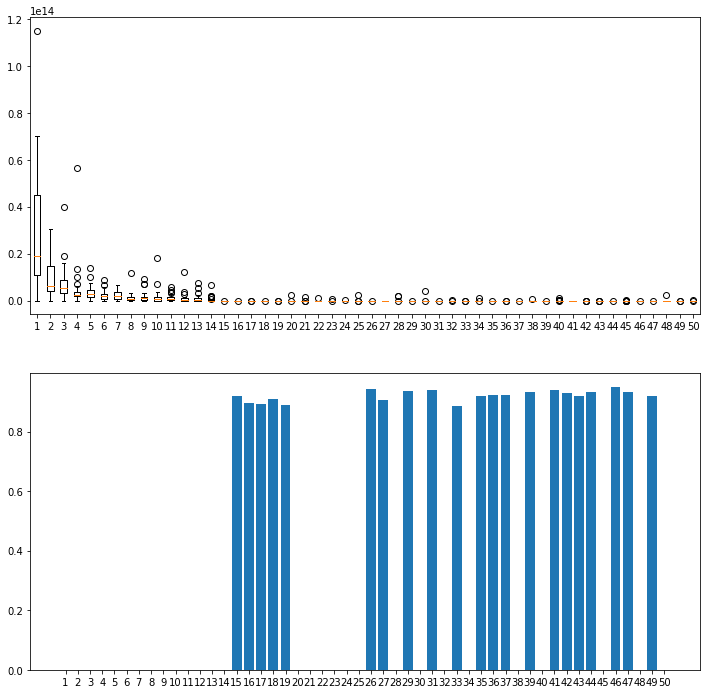

In [133]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

# Check how pca could tell us without log2 preprocess

In [176]:
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_15 = pca.inverse_transform(pca_df)
residule_15 = gse - approx_15
# pca checks result
pca = PCA(n_components = 26)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_26 = pca.inverse_transform(pca_df)
residule_26 = gse - approx_26
# pca checks result
pca = PCA(n_components = 41)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_41 = pca.inverse_transform(pca_df)
residule_41 = gse - approx_41

In [177]:
m_15 = residule_15.mean().mean()
s_15 = residule_15.std().std()
m_26 = residule_26.mean().mean()
s_26 = residule_26.std().std()
m_41 = residule_41.mean().mean()
s_41 = residule_41.std().std()

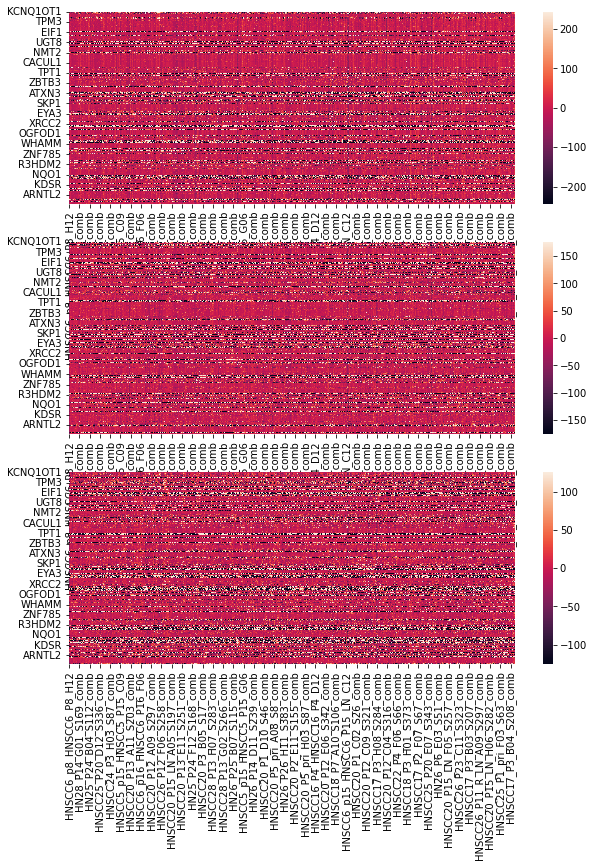

In [158]:
plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.heatmap(residule_15, vmin=m_15-3*s_15, vmax=m_15+3*s_15);
plt.subplot(3,1,2)
sns.heatmap(residule_26, vmin=m_26-3*s_26, vmax=m_26+3*s_26);
plt.subplot(3,1,3)
sns.heatmap(residule_41, vmin=m_41-3*s_41, vmax=m_41+3*s_41);

In [178]:
m_15 = approx_15.mean().mean()
s_15 = approx_15.std().std()
m_26 = approx_26.mean().mean()
s_26 = approx_26.std().std()
m_41 = approx_41.mean().mean()
s_41 = approx_41.std().std()
m = gse.mean().mean()
s = gse.std().std()

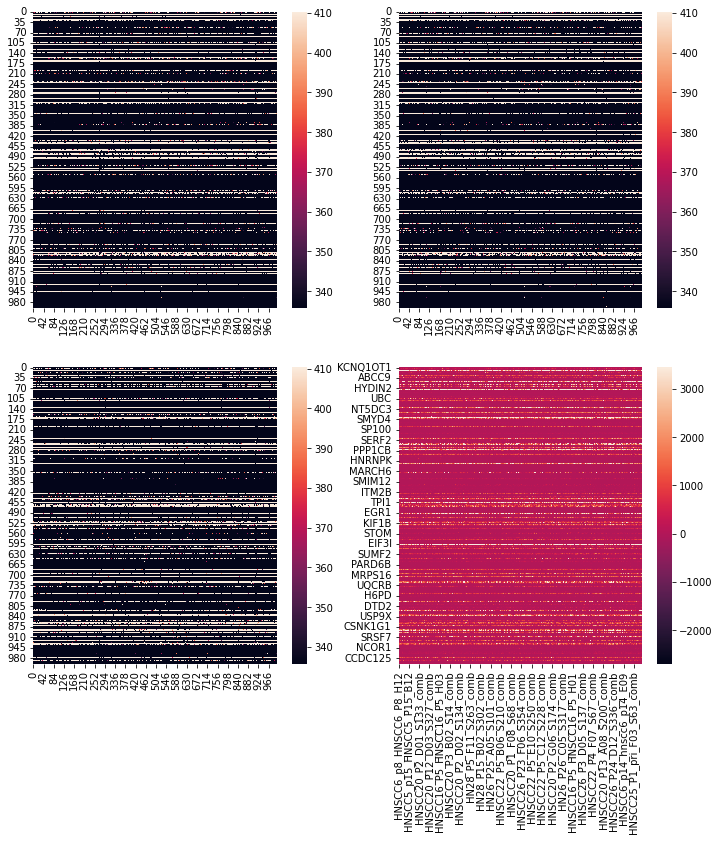

In [163]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(approx_15, vmin=m_15-3*s_15, vmax=m_15+3*s_15);
plt.subplot(2,2,2)
sns.heatmap(approx_26, vmin=m_26-3*s_26, vmax=m_26+3*s_26);
plt.subplot(2,2,3)
sns.heatmap(approx_41, vmin=m_41-3*s_41, vmax=m_41+3*s_41);
plt.subplot(2,2,4)
sns.heatmap(gse, vmin=m-3*s, vmax=m+3*s);

In [179]:
# pca checks result
pca = PCA(n_components = 14)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_14 = pca.inverse_transform(pca_df)
residule_14 = gse - approx_14
m_14 = approx_14.mean().mean()
s_14 = approx_14.std().std()
# pca checks result
pca = PCA(n_components = 10)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_10 = pca.inverse_transform(pca_df)
residule_10 = gse - approx_10
m_10 = approx_10.mean().mean()
s_10 = approx_10.std().std()

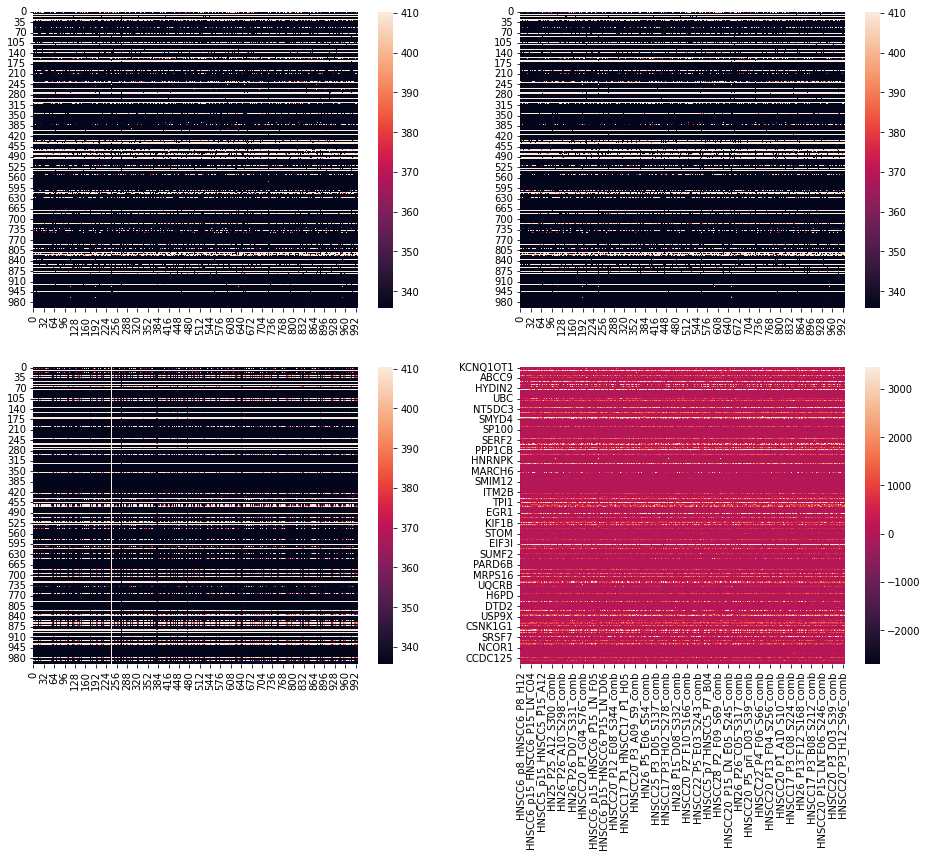

In [180]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
sns.heatmap(approx_15, vmin=m_15-3*s_15, vmax=m_15+3*s_15);
plt.subplot(2,2,2)
sns.heatmap(approx_10, vmin=m_10-3*s_10, vmax=m_10+3*s_10);
plt.subplot(2,2,3)
sns.heatmap(approx_14, vmin=m_14-3*s_14, vmax=m_14+3*s_14);
plt.subplot(2,2,4)
sns.heatmap(gse, vmin=m-3*s, vmax=m+3*s);

# Try log2 preprocess

In [112]:
# choose 1000 x 1000 left-upper corner submatrix
gse = np.log2(data+1).copy()
gse = gse[pre.columns[0:1000]]
gse = gse.loc[pre.index[0:1000]]

In [113]:
times = 30
num_comps = 30
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse,times,num_comps,10,10)

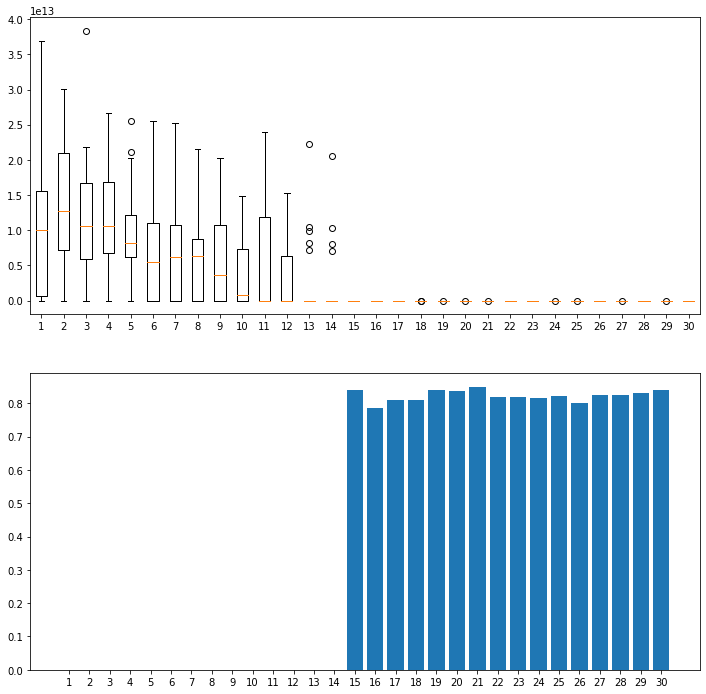

In [114]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [115]:
q2_A

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.847764,0.820462,0.817926,0.816905,0.823186,0.801253,0.825141,0.823891,0.830979,0.841356


In [16]:
times = 30
num_comps = 30
error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
#error_t,  q2_A = bcv(gse,times,num_comps,10,10)

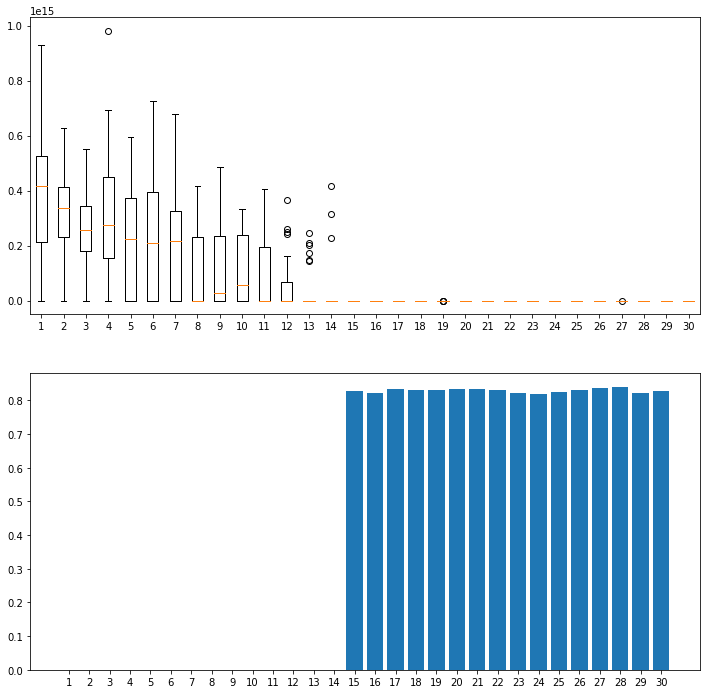

In [17]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

# Add a pattern to the matrix, Normal Distribution

In [121]:
gaussian = np.random.normal(4,3.5,size=(100,100))
attach = pd.DataFrame(np.pad(gaussian,((0,900),(0,900)),'constant',constant_values = (0,0)), index = gse.index, columns = gse.columns)
gse_v2 = gse + attach

In [82]:
times = 30
num_comps = 20
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse_v2,times,num_comps,10,10)

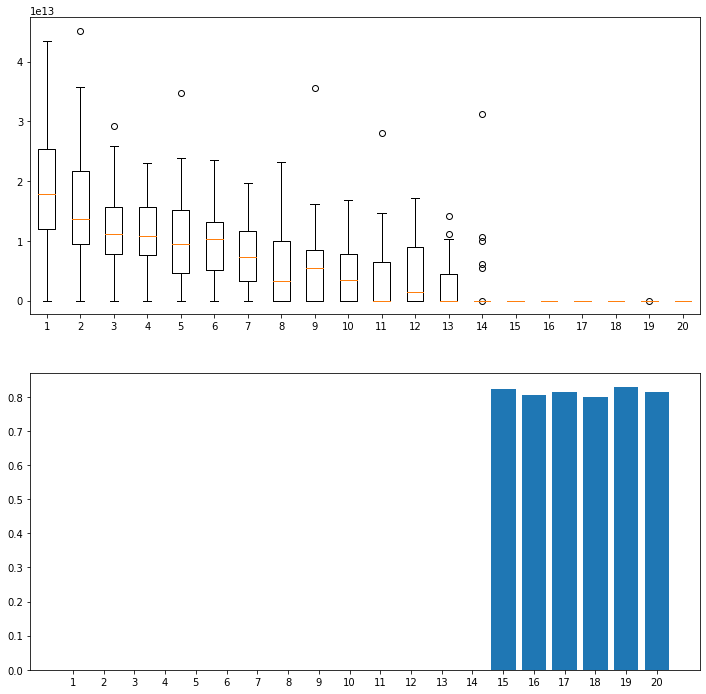

In [83]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [66]:
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse_v2)
pca_df = pca.transform(gse_v2)
approx_15 = pca.inverse_transform(pca_df)
residule = gse_v2 - approx_15

In [201]:
# pca checks result
pca = PCA(n_components = 1)
pca.fit(gse_v2)
pca_df = pca.transform(gse_v2)
approx_1 = pca.inverse_transform(pca_df)
residule_1 = gse_v2 - approx_1
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse_v2)
pca_df = pca.transform(gse_v2)
approx_15 = pca.inverse_transform(pca_df)
residule_15 = gse_v2 - approx_15
# pca checks result
pca = PCA(n_components = 4)
pca.fit(gse_v2)
pca_df = pca.transform(gse_v2)
approx_10 = pca.inverse_transform(pca_df)
residule_10 = gse_v2 - approx_10

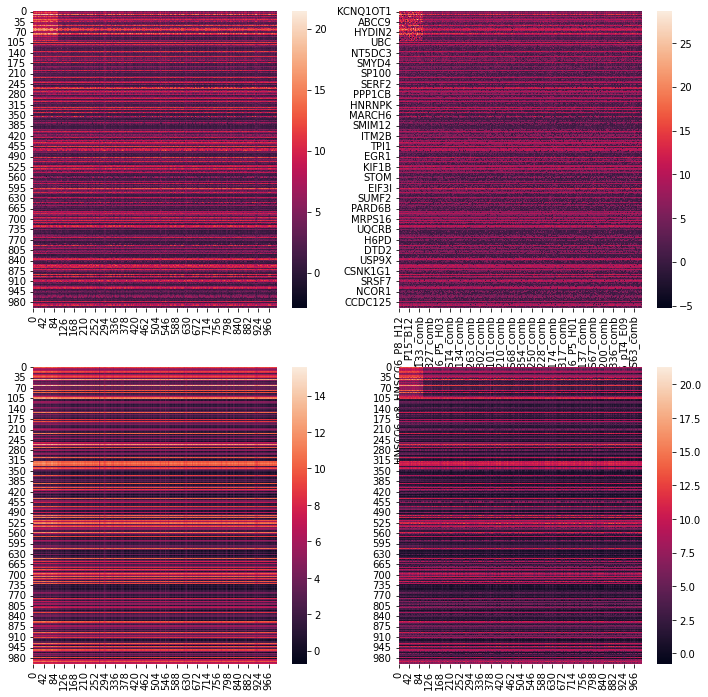

In [202]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(approx_15);
plt.subplot(2,2,2)
sns.heatmap(gse_v2);
plt.subplot(2,2,3)
sns.heatmap(approx_1);
plt.subplot(2,2,4)
sns.heatmap(approx_10);

# Try Uniform Distribution

In [123]:
uni = np.random.uniform(0,10,100*100).reshape(100,100)
attach = pd.DataFrame(np.pad(uni,((0,900),(0,900)),'constant',constant_values = (0,0)), index = gse.index, columns = gse.columns)
gse_v3 = gse + attach

In [124]:
times = 30
num_comps = 20
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse_v3,times,num_comps,10,10)

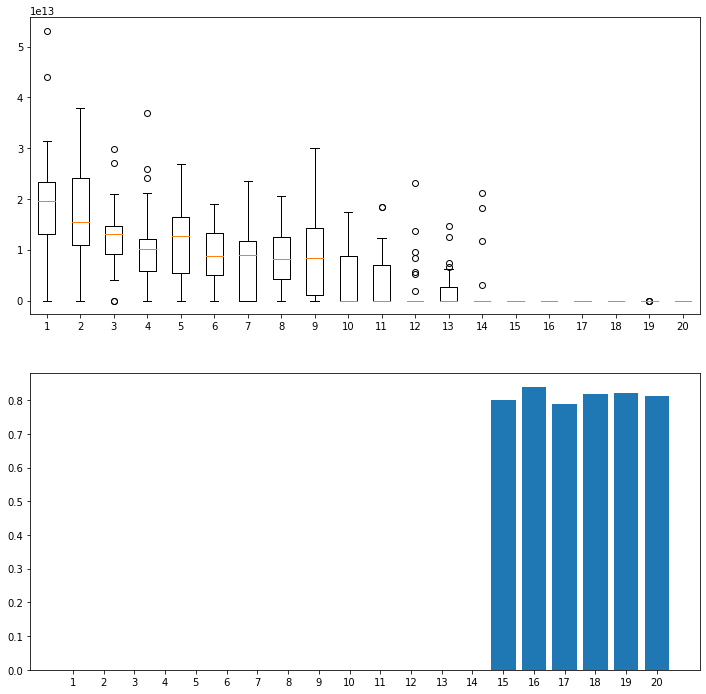

In [125]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [126]:
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse_v3)
pca_df = pca.transform(gse_v3)
approx = pca.inverse_transform(pca_df)
residule = gse_v3 - approx

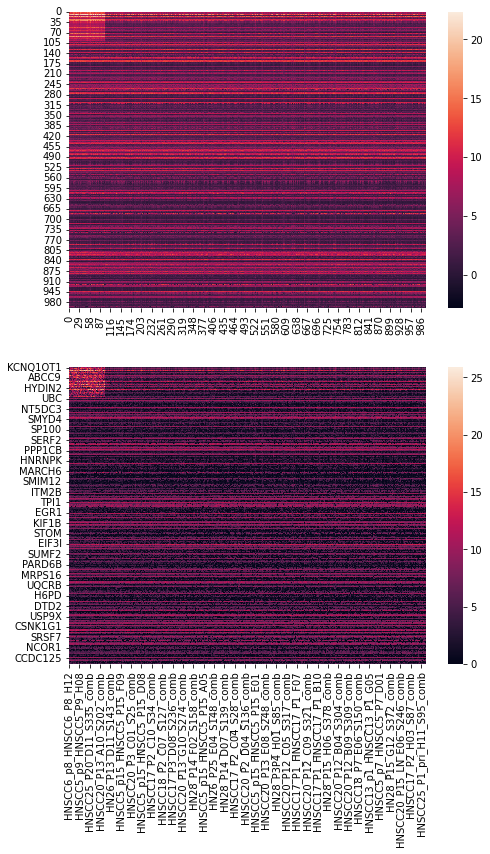

In [127]:
plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
sns.heatmap(approx);
plt.subplot(2,1,2)
sns.heatmap(gse_v3);

Text(0, 0.5, 'explained variance ratio(%)')

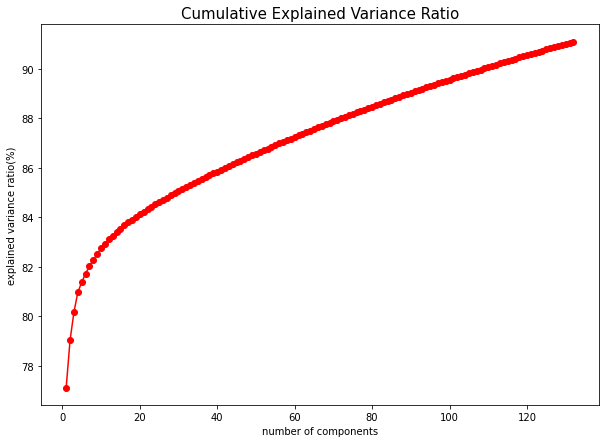

In [91]:
data_norm = scale(gse_v2)
pca = PCA(n_components = 'mle')
pca.fit(data_norm)
evr = pca.explained_variance_ratio_ * 100
# 查看累计解释方差比率与主成分个数的关系
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(1, len(evr) + 1), np.cumsum(evr), "-ro")
ax.set_title("Cumulative Explained Variance Ratio", fontsize=15)
ax.set_xlabel("number of components")
ax.set_ylabel("explained variance ratio(%)")

# check svd on gse

In [204]:
u,s,vh = np.linalg.svd(gse)

In [211]:
list(s>1).count(True)

994